In [22]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/A-Z Dataset/A_Z Handwritten Data.csv.zip"

In [4]:
with ZipFile(zip_path) as zipfile:
    zipfile.extractall()

In [5]:
csv_path = "/content/A_Z Handwritten Data.csv"

In [6]:
df = pd.read_csv(csv_path)

In [7]:
X = df.drop('0',axis = 1).to_numpy() # axis=1 is to say to drop along the columns
y = df['0'].to_numpy()

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [9]:
del df

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

In [11]:
class Alphabets(Dataset):

  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):

    image = Image.fromarray(((self.X[index]).astype(np.uint8)).reshape(28,28))
    label = self.y[index]

    if self.transform != None:
      image = self.transform(image)
    
    return image,label


In [27]:
transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.RandomAffine(degrees=(-50,50),
                                 translate=(0.2, 0.2),
                                 scale=(0.5, 0.75),
                                 shear=(-30, 30, -30, 30))                      
])

In [28]:
train_dataset = Alphabets(X_train,y_train,transform)
test_dataset = Alphabets(X_test,y_test,transform)
val_dataset = Alphabets(X_val,y_val,transform)

In [29]:
train_dataset_loader = DataLoader(train_dataset,batch_size=100,shuffle=True)
test_dataset_loader = DataLoader(test_dataset,batch_size=100,shuffle=True)
val_dataset_loader = DataLoader(val_dataset,batch_size=100,shuffle=True)

In [30]:
import torchvision

inputs_batch, labels_batch = next(iter(train_dataset_loader))
grid = torchvision.utils.make_grid(inputs_batch, nrow=40, pad_value=1)
torchvision.utils.save_image(grid, 'inputs_batch_preview.png')

In [31]:
class NeuralNetwork(nn.Module):

  def __init__(self):
    super(NeuralNetwork,self).__init__()

    self.layer1 = nn.Sequential(
      nn.Conv2d(1,16,3,1,1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(16,32,3,1,1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(32,64,3,1,1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(64,128,3,1,1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.FC = nn.Sequential(
      nn.Linear(128,26)
    )


  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = torch.flatten(x,1)
    x = self.FC(x)

    return x



In [32]:
net = NeuralNetwork()
net.train()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [33]:
net.load_state_dict(torch.load("/content/englishv2.pt"))

<All keys matched successfully>

In [35]:
lr = 0.01
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(),lr)

In [36]:
epochs = 15

train_len = len(train_dataset_loader)
val_len = len(val_dataset_loader)

training_accuracy = []
training_loss = []

validation_accuracy = []
validation_loss = []

for epoch in range(epochs):

  epoch_acc = 0
  epoch_loss = 0

  for batch_id,(image,label) in enumerate(train_dataset_loader):

    output = net(image)

    loss = loss_fn(output,label)

    optim.zero_grad()
    loss.backward()
    optim.step()

    acc = (output.argmax(dim=1) == label).float().mean()
    epoch_acc += (acc.item() / len(train_dataset_loader)) 
    epoch_loss += (loss.item() / len(train_dataset_loader)) 
  
  print(f"Epoch :: [{epoch+1}/{epochs}] Train Accuracy :: {epoch_acc:.4f} Train Loss :: {epoch_loss:.4f}") 
  
  training_accuracy.append(epoch_acc)
  training_loss.append(epoch_loss)

  with torch.no_grad():

    epoch_val_accuracy = 0
    epoch_val_loss = 0
    
    for batch_id,(image, label) in enumerate(val_dataset_loader):
  
      val_output = net(image)
      val_loss = loss_fn(val_output,label)
      
      val_acc = ((val_output.argmax(dim=1) == label).float().mean())
      epoch_val_accuracy += (val_acc.item() / len(val_dataset_loader))  
      epoch_val_loss += (val_loss.item() / len(val_dataset_loader))

    print(f"Epoch :: [{epoch+1}/{epochs}] Val Accuracy :: {epoch_val_accuracy:.4f} Val Loss :: {epoch_val_loss:.4f}")

    validation_accuracy.append(epoch_val_accuracy)
    validation_loss.append(epoch_val_loss)
    

Epoch :: [1/15] Train Accuracy :: 0.8861 Train Loss :: 0.3760
Epoch :: [1/15] Val Accuracy :: 0.9034 Val Loss :: 0.3156
Epoch :: [2/15] Train Accuracy :: 0.9073 Train Loss :: 0.3016
Epoch :: [2/15] Val Accuracy :: 0.9129 Val Loss :: 0.2865
Epoch :: [3/15] Train Accuracy :: 0.9139 Train Loss :: 0.2795
Epoch :: [3/15] Val Accuracy :: 0.9158 Val Loss :: 0.2769
Epoch :: [4/15] Train Accuracy :: 0.9181 Train Loss :: 0.2678
Epoch :: [4/15] Val Accuracy :: 0.9184 Val Loss :: 0.2650
Epoch :: [5/15] Train Accuracy :: 0.9196 Train Loss :: 0.2612
Epoch :: [5/15] Val Accuracy :: 0.9204 Val Loss :: 0.2578
Epoch :: [6/15] Train Accuracy :: 0.9208 Train Loss :: 0.2565
Epoch :: [6/15] Val Accuracy :: 0.9208 Val Loss :: 0.2605
Epoch :: [7/15] Train Accuracy :: 0.9234 Train Loss :: 0.2491
Epoch :: [7/15] Val Accuracy :: 0.9215 Val Loss :: 0.2566
Epoch :: [8/15] Train Accuracy :: 0.9239 Train Loss :: 0.2471
Epoch :: [8/15] Val Accuracy :: 0.9242 Val Loss :: 0.2501
Epoch :: [9/15] Train Accuracy :: 0.9262

In [49]:
torch.save(net.state_dict,"englishv5.pt")

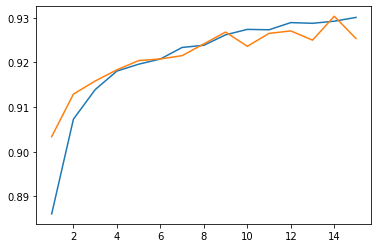

In [47]:
import matplotlib.pyplot as plt 

epochs_ = list(range(1,16))

plt.plot(epochs_,training_accuracy)
plt.plot(epochs_,validation_accuracy)

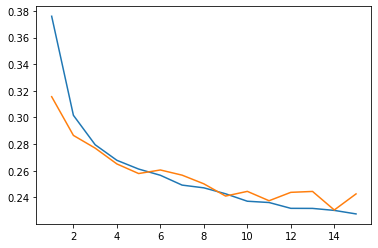

In [48]:
epochs_ = list(range(1,16))

plt.plot(epochs_,training_loss)
plt.plot(epochs_,validation_loss)